<a href="https://colab.research.google.com/github/Zafar-Lab/scDREAMER/blob/main/2109_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

2023-09-25 16:32:17.913282: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 16:32:18.606615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:

np.random.seed(0)
tf.set_random_seed(0)
random.seed(0)
tf2.random.set_seed(0)
tf2.keras.utils.set_random_seed(0)


In [3]:
import warnings
warnings.filterwarnings('ignore')
"""
!pip install -U scipy==1.5.0
!pip install scanpy==1.8.2
!pip install -U scikit-learn
"""

'\n!pip install -U scipy==1.5.0\n!pip install scanpy==1.8.2\n!pip install -U scikit-learn\n'

Building model

In [4]:


name = "Lung"


"""
NOTE:
Run setting as follows:
0: Supervised setting
10: 10 percent missing labels data
20: 20 percent missing labels data
50: 50 percent missing labels data
"""
run_setting = 0

In [5]:
"""

0: Supervised setting
10: 10% missing labels
20: 20% missing labels
50: 50% missing labels

"""

path = "/home/ajita/Documents/data_integration/"

data_path = {
    
"Immune_Human" : {0: path + "Immune/Immune_ALL_human.h5ad",
                  10: path + "Immune/Immune_Human_NA_0.1.h5ad",
                  20: path + "Immune/Immune_Human_NA_0.2.h5ad",
                  50: path + "Immune/Immune_Human_NA_0.5.h5ad"
                 },
    
"Human_Mouse" : {
                0: path + "hum_mou/hcl_mca_merged.h5ad"},
    
"Human_Retina" : {
                0: path + "Human_Retina/Human_Retina.h5ad"},
    
"Lung" : { 0: path + "Lung/Lung_atlas_public.h5ad",
          10: path + "Lung/Lung_NA_0.1.h5ad",
          20: path + "Lung/Lung_NA_0.2.h5ad",
          50: path + "Lung/Lung_NA_0.5.h5ad"
         },
    
"Healthy_Heart" : {
        0: path + "Healthy_Heart/Healthy_human_heart_adata.h5ad",
        20: path + "Healthy_Heart/Healthy_human_heart_adata_NA_0.2.h5ad",
        50: path + "Healthy_Heart/Healthy_human_heart_adata_NA_0.5.h5ad"}
}


batch_key_dict = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch",
                 "Healthy_Heart" : "sampleID"
                 
                }

cell_type_key_dict = {
    
"Immune_Human" : {0: "final_annotation", 10: "final_annotation_NA",
                  20: "final_annotation_NA", 50: "final_annotation_NA"
                 },
    
"Human_Mouse" : {
                0: "celltype"},
    
"Human_Retina" : {
                0: "Subcluster"},
    
"Lung" : { 0: "cell_type",
          10: "cell_type_NA",
          20: "cell_type_NA",
          50: "cell_type_NA"
         },
    
"Healthy_Heart" : {
        0: "celltype",
        20: "celltype_NA",
        50: "celltype_NA"},
    
"Human_Mouse" : {
     0: "celltype"
    }    
}
 
shuffle_type_dict = {
"Immune_Human" : {0: 1, 10: 2, 20: 2, 50: 2 },    
"Human_Retina" : { 0: 1},
"Lung" : { 0: 1,10: 2, 20: 2, 50: 2}, 
"Healthy_Heart" : {0: 1, 20: 1,50: 1},    
"Human_Mouse" : {0: 1}}

lr = {"lr_ae" : 0.0002, "lr_dis": 0.0007, "lr_bc": 0.0007}
lr_big_data = {"lr_ae" : 0.0002, "lr_dis": 0.00001, "lr_bc": 0.0007}

learning_rate = {
"Immune_Human" : {0: lr, 10: lr, 20: lr, 50: lr },    
"Human_Retina" : { 0: lr},
"Lung" : { 0: lr,10: lr, 20: lr, 50: lr}, 
"Healthy_Heart" : {0: lr_big_data, 20: lr_big_data, 50: lr_big_data},    
"Human_Mouse" : {0: {"lr_ae" : 0.00005, "lr_dis": 0.00001, "lr_bc": 0.0007}}}


# big datasets: 20 dimensions
latent_dim = {
                'Immune_Human' : 10,
                 'Lung' : 10,
                 'Pancreas' : 10,
                 'Human_Mouse' : 20,
                 'Human_Retina': 10,
                 "Healthy_Heart" : 20
    
            }

BS = {
"Immune_Human" : {0: 256, 10: 128, 20: 128, 50: 128 },    
"Human_Retina" : { 0: 256},
"Lung" : { 0: 256,10: 128, 20: 128, 50: 128}, 
"Healthy_Heart" : {0: 128, 20: 128,50: 128},    
"Human_Mouse" : {0: 128}}


epoch_dict = {
    'Immune_Human' : 300,
     'Lung' : 300,
     'Human_Mouse' : 300,
     'Human_Retina': 300,
     "Healthy_Heart" : 300
}

plot_cell_type_dict = {
                    "Healthy_Heart" : "celltype",
                    'Immune_Human' : 'final_annotation', 
                 'Lung' : 'cell_type',
                 'Pancreas' : 'celltype',
                 'Human_Mouse' : "celltype",
                 "Human_Retina":"Subcluster"
                    } 

"""
Below variable takes care of sparse matrix
If 1: pd.DataFrame.sparse.from_spmatrix(Ann.X) is used
If 0: pd.DataFrame(Ann.X)

By default 0, unless scarcity not handled by basis pandas operation
"""

sparseIP= {
        "Healthy_Heart" : 1,
    'Immune_Human' : 0, 
     'Lung' : 1,
     'Pancreas' : 0,
     'Human_Mouse' : 1,
     "Human_Retina": 0
}

2023-09-25 16:32:21.401517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5367 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d8:00.0, compute capability: 7.5


Loading dataset
Preprocessing...
here [16 16 16 ... 10 10 10]
Shape self.data_train: (32472, 2000)
Shape self.data_test: (32472, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2016), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 26), dtype=float32)
inferred check Tensor("Max:0", shape=(), dtype=float32)
entering in for loop 1   512  -- > 256
KL gaussian z Tensor("mul_13:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_12:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cluster DRA on DataSet /home/ajita/Documents/data_integration/Lung/Lung_atlas_public.h5ad ... 


2023-09-25 16:32:33.990430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Epoch : [0] ,  a_loss = 459.8608, d_loss: -0.0677 , db_loss: 1.9999
Epoch : [1] ,  a_loss = 455.5844, d_loss: -0.5136 , db_loss: 1.7479
Epoch : [2] ,  a_loss = 435.5950, d_loss: -0.2928 , db_loss: 1.4273
Epoch : [3] ,  a_loss = 420.4702, d_loss: -0.2714 , db_loss: 1.3256
Epoch : [4] ,  a_loss = 407.9091, d_loss: -0.5511 , db_loss: 1.2816
Epoch : [5] ,  a_loss = 394.8727, d_loss: -0.1081 , db_loss: 1.1872
Epoch : [6] ,  a_loss = 396.7954, d_loss: -0.0899 , db_loss: 1.1077
Epoch : [7] ,  a_loss = 404.2124, d_loss: -0.1020 , db_loss: 1.1261
Epoch : [8] ,  a_loss = 408.6214, d_loss: -0.0917 , db_loss: 1.1651
Epoch : [9] ,  a_loss = 405.5693, d_loss: -0.1288 , db_loss: 1.1313
Epoch : [10] ,  a_loss = 393.1590, d_loss: -0.1240 , db_loss: 1.0609
Epoch : [11] ,  a_loss = 403.9442, d_loss: -0.1573 , db_loss: 0.9787
Epoch : [12] ,  a_loss = 389.1537, d_loss: -0.2426 , db_loss: 1.1080
Epoch : [13] ,  a_loss = 385.7605, d_loss: -0.2715 , db_loss: 1.0517
Epoch : [14] ,  a_loss = 393.3917, d_loss: -

Epoch : [119] ,  a_loss = 324.0728, d_loss: -1.5557 , db_loss: 1.4033
Epoch : [120] ,  a_loss = 331.4186, d_loss: -1.1469 , db_loss: 1.5032
Epoch : [121] ,  a_loss = 333.1282, d_loss: -1.4355 , db_loss: 1.5268
Epoch : [122] ,  a_loss = 321.5015, d_loss: -1.7440 , db_loss: 1.4292
Epoch : [123] ,  a_loss = 326.8337, d_loss: -1.1661 , db_loss: 1.5506
Epoch : [124] ,  a_loss = 318.3191, d_loss: -1.4818 , db_loss: 1.5511
Epoch : [125] ,  a_loss = 316.1923, d_loss: -1.1340 , db_loss: 1.4616
Epoch : [126] ,  a_loss = 324.8682, d_loss: -1.5017 , db_loss: 1.5294
Epoch : [127] ,  a_loss = 335.2131, d_loss: -1.1172 , db_loss: 1.5245
Epoch : [128] ,  a_loss = 334.1673, d_loss: -1.0175 , db_loss: 1.5114
Epoch : [129] ,  a_loss = 331.0774, d_loss: -1.3833 , db_loss: 1.4420
Epoch : [130] ,  a_loss = 330.7322, d_loss: -1.4709 , db_loss: 1.5021
Epoch : [131] ,  a_loss = 321.5688, d_loss: -1.3610 , db_loss: 1.4967
Epoch : [132] ,  a_loss = 326.9659, d_loss: -1.3927 , db_loss: 1.4331
Epoch : [133] ,  a_l

Epoch : [237] ,  a_loss = 325.3195, d_loss: -1.6036 , db_loss: 1.5985
Epoch : [238] ,  a_loss = 312.0142, d_loss: -1.4809 , db_loss: 1.4083
Epoch : [239] ,  a_loss = 314.7439, d_loss: -1.4876 , db_loss: 1.4634
Epoch : [240] ,  a_loss = 327.7422, d_loss: -1.9352 , db_loss: 1.4571
Epoch : [241] ,  a_loss = 323.8391, d_loss: -1.6933 , db_loss: 1.5312
Epoch : [242] ,  a_loss = 318.9660, d_loss: -1.6456 , db_loss: 1.6184
Epoch : [243] ,  a_loss = 330.5958, d_loss: -2.0260 , db_loss: 1.4520
Epoch : [244] ,  a_loss = 326.0331, d_loss: -1.8925 , db_loss: 1.4842
Epoch : [245] ,  a_loss = 320.7321, d_loss: -1.3015 , db_loss: 1.5896
Epoch : [246] ,  a_loss = 319.3720, d_loss: -1.4899 , db_loss: 1.5821
Epoch : [247] ,  a_loss = 322.0205, d_loss: -1.5135 , db_loss: 1.5188
Epoch : [248] ,  a_loss = 325.4362, d_loss: -1.1122 , db_loss: 1.5472
Epoch : [249] ,  a_loss = 319.0049, d_loss: -2.4307 , db_loss: 1.5121
Epoch : [250] ,  a_loss = 307.8951, d_loss: -1.1621 , db_loss: 1.5474
Epoch : [251] ,  a_l

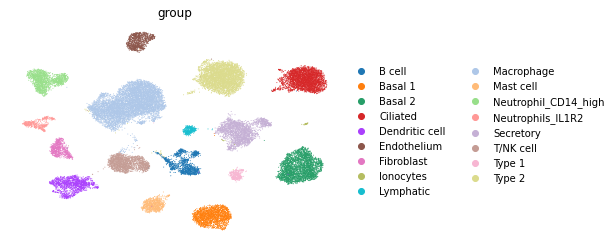

None


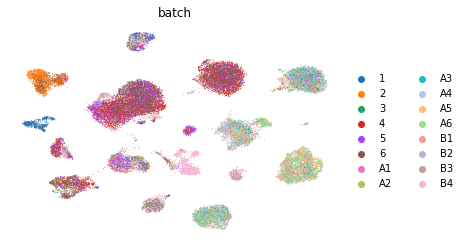

None
Computing NMI ...
Done !
NMI = 0.943658153792625


In [6]:

# Add avg of losses

import src.model as model


run_config = tf.ConfigProto()

run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

with tf.Session(config = run_config) as sess:

    dreamer = model.scDREAMER(
        sess,
        epoch = epoch_dict[name],
        dataset_name = data_path[name][run_setting],
        batch = batch_key_dict[name],
        cell_type = cell_type_key_dict[name][run_setting],
        plot_cell_type = plot_cell_type_dict[name],
        name = name,
        lr_ae = learning_rate[name][run_setting]['lr_ae'],
        lr_dis = learning_rate[name][run_setting]['lr_dis'],
        lr_bc = learning_rate[name][run_setting]['lr_bc'],
        batch_size = BS[name][run_setting],
        z_dim = latent_dim[name],
        shuffle_type = shuffle_type_dict[name][run_setting],
        sparseIP = sparseIP[name]
        )

    dreamer.train_cluster()

    